# Network infodemic model

Garland Culbreth

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import polars as pl
from tqdm import tqdm

In [2]:
from model import functions as nimodel
from utils import functions as niutils
plt.style.use("aeon")

## Specify options
---

In [3]:
tmax = 400
number_of_nodes = 40
init_neighbor_edge_weight = 0.1
init_non_neighbor_edge_weight = 0.01
reciprocate_interactions = True

## Initialize network and attitudes
---

In [4]:
G_social = nimodel.create_network(
    network_type="watts_strogatz",
    number_of_nodes=number_of_nodes
)

Initialize and view starting attitudes.

In [5]:
attitudes = nimodel.initialize_attitudes(
    number_of_nodes,
    distribution="normal",
    loc=0.0,
    scale=0.1
)

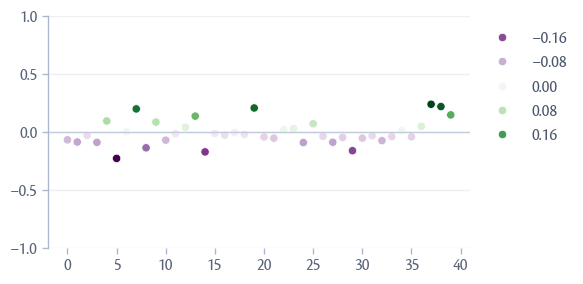

In [6]:
niutils.plot_initial_attitudes(attitudes, number_of_nodes)

Initialize interaction dynamics

In [7]:
A_social = nimodel.initialize_edges(
    G_social=G_social,
    neighbor_weight=init_neighbor_edge_weight,
    non_neighbor_weight=init_non_neighbor_edge_weight
)

## Run simulation
---

In [8]:
# Set up dataframe to track the attitudes over time
attitude_tracker = pl.DataFrame({
    "time": np.repeat(0, repeats=number_of_nodes),
    "node": np.arange(number_of_nodes),
    "attitude": attitudes
})
sim_summary = pl.DataFrame({
    "time": 0,
    "edge_weight_mean": np.mean(A_social),
    "edge_weight_median": np.median(A_social),
    "edge_weight_sd": np.std(A_social),
    "attitude_mean": np.mean(attitudes),
    "attitude_median" : np.median(attitudes),
    "attitude_sd": np.std(attitudes)
})
# Run the simulation
for t in tqdm(range(tmax)):
    A_interaction = nimodel.make_interactions(
        A_social,
        number_of_nodes,
        reciprocate_interactions
    )
    A_social = nimodel.update_edges(
        A_social,
        A_interaction,
        attitudes,
        method="type1"
    )
    attitudes = nimodel.update_attitudes(
        A_social,
        A_interaction,
        attitudes,
        method="type1"
    )
    # Add new rows to track nodes over time
    attitudes_t = pl.DataFrame({
        "time": np.repeat(t, repeats=number_of_nodes),
        "node": np.arange(number_of_nodes),
        "attitude": attitudes
    })
    sim_summary_t = pl.DataFrame({
        "time": t,
        "edge_weight_mean": np.mean(A_social),
        "edge_weight_median": np.median(A_social),
        "edge_weight_sd": np.std(A_social),
        "attitude_mean": np.mean(attitudes),
        "attitude_median" : np.median(attitudes),
        "attitude_sd": np.std(attitudes)
    })
    attitude_tracker = pl.concat([attitude_tracker, attitudes_t])
    sim_summary = pl.concat([sim_summary, sim_summary_t])

100%|██████████| 400/400 [00:02<00:00, 146.59it/s]


## Results
---

Plot all the node attitudes over time.

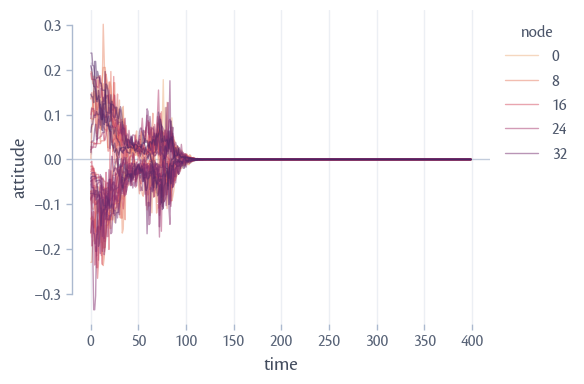

In [9]:
niutils.plot_attitude_evolution(attitude_tracker, tmax)

View the summary table.

In [10]:
sim_summary

time,edge_weight_mean,edge_weight_median,edge_weight_sd,attitude_mean,attitude_median,attitude_sd
i64,f64,f64,f64,f64,f64,f64
0,0.0145,0.01,0.019615,-0.005976,-0.030045,0.105627
0,0.014988,0.01,0.021792,-0.003967,-0.028816,0.105161
1,0.015549,0.01,0.025463,-0.003958,-0.026392,0.108898
2,0.016537,0.01,0.029016,-0.010925,-0.031011,0.106428
3,0.017491,0.01,0.033215,-0.014214,-0.035067,0.119764
4,0.018156,0.01,0.036162,-0.016056,-0.043509,0.127669
5,0.019097,0.01,0.03979,-0.023795,-0.04593,0.124939
6,0.020521,0.01,0.044673,-0.029429,-0.051398,0.114464
7,0.021325,0.01,0.047112,-0.025327,-0.057396,0.119187
